In [1]:
import omicverse as ov
import scanpy as sc
import matplotlib
import matplotlib.pyplot as plt
import gc
import os


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.7, Tutorials: https://omicverse.readthedocs.io/


In [2]:
%matplotlib inline
import omicverse as ov
ov.utils.ov_plot_set()

Dependency error: (pydeseq2 0.4.12 (/mnt/home/yihanzhao/miniconda3/envs/zyh/lib/python3.10/site-packages), Requirement.parse('pydeseq2<=0.4.0,>=0.3'))


In [3]:
import scvi

In [6]:
scvi.model.utils

<module 'scvi.model.utils' from '/mnt/home/yihanzhao/miniconda3/envs/zyh/lib/python3.10/site-packages/scvi/model/utils/__init__.py'>

In [9]:
pathway_dict=ov.utils.geneset_prepare('/mnt/home/zehuazeng/analysis/placenta/genesets/WikiPathway_2021_Human.txt',organism='Human')

## scbasset

In [ ]:
! wget https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/pwm_ad.h5ad -O /mnt/home/yihanzhao/RB/data/pwm_ad.h5ad 

In [3]:
pwm = sc.read('/mnt/home/yihanzhao/RB/data/pwm_ad.h5ad')
pwm

AnnData object with n_obs × n_vars = 246113 × 729

In [5]:
rna=sc.read_h5ad('/mnt/home/yihanzhao/RB/data_new/rna_rb_pair_zhushi.h5ad')
rna

AnnData object with n_obs × n_vars = 729 × 16801
    obs: 'tissue', 'domain', 'sample', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'leiden', 'celltype', 'balancing_weight'
    var: 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
    uns: 'celltype_colors'
    obsm: 'X_glue', 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'X_umap', 'scaled|original|X_pca'
    varm: 'scaled|original|pca_loadings'
    layers: 'counts', 'lognorm', 'scaled'

In [5]:
# Filter PWM to TFs present in dataset
has_expr = [g in rna.var_names for g in pwm.var_names]
frac = sum(has_expr) / len(has_expr)
print(f"{frac:.2%} ({sum(has_expr)}) TFs have expresssion")

pwm = pwm[:, has_expr]

70.78% (516) TFs have expresssion


In [6]:
var_index = pwm.var.index
var_index.to_frame(index=True, name='tf').to_csv('/mnt/home/yihanzhao/RB/data_new/var_index.csv', index_label='Index')

In [7]:
atac=sc.read_h5ad('/mnt/home/yihanzhao/RB/data_new/atac_rb_pair_zhushi.h5ad')
atac

AnnData object with n_obs × n_vars = 729 × 150000
    obs: 'sample', 'tissue', 'domain', 'week', 'balancing_weight', 'celltype'
    var: 'chrom', 'chromStart', 'chromEnd', 'highly_variable'
    uns: 'celltype_colors'
    obsm: 'X_glue', 'X_lsi', 'X_mde_lsi', 'X_umap'

In [10]:
atac.obsm["X_mde_scglue"] = ov.utils.mde(atac.obsm["X_glue"])

<AxesSubplot: title={'center': 'celltype'}, xlabel='X_mde_lsi1', ylabel='X_mde_lsi2'>

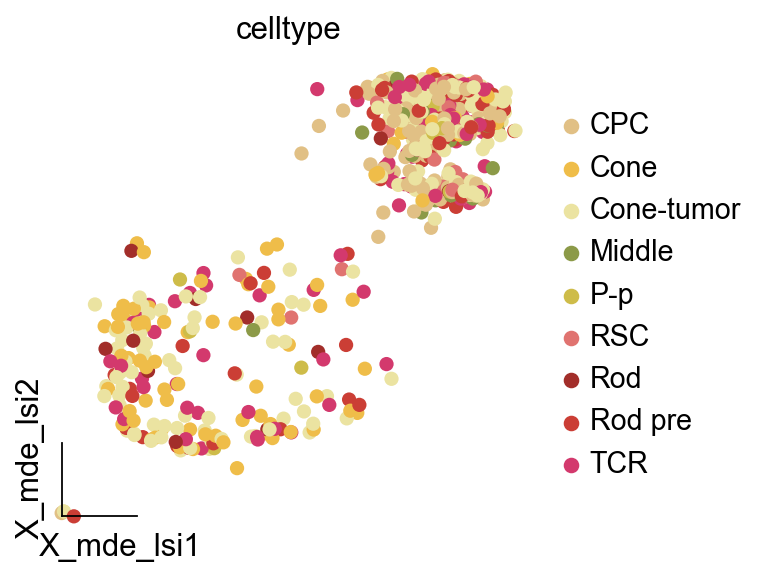

In [13]:
ov.utils.embedding(atac,
                basis='X_mde_lsi',frameon='small',palette=ov.utils.orange_color[5:6]+ov.utils.orange_color[0:1]+ov.utils.orange_color[7:8]+ov.utils.orange_color[9:10]+ov.utils.orange_color[6:7]+ov.utils.red_color[1:2]+ov.utils.red_color[3:4]+ov.utils.red_color[2:3]+ov.utils.red_color[5:],
                color=['celltype'],show=False)

In [24]:
atac.var['chromstart']=atac.var['chromStart']
atac.var['chromend']=atac.var['chromEnd']

In [33]:
adata=atac

In [45]:
# Filter out non-chromosomal regions
mask = adata.var["chrom"].str.startswith("chr")
adata = adata[:, mask].copy()

In [ ]:
scvi.data.add_dna_sequence(
    adata,
    genome_name="hg38", 
    genome_dir="data",
    chr_var_key="chrom",
    start_var_key="chromstart",
    end_var_key="chromend",
)
adata

In [52]:
import numpy as np

In [66]:
bdata = adata.transpose()
bdata.layers["binary"] = (bdata.X.copy() > 0).astype(float)
scvi.external.SCBASSET.setup_anndata(bdata, layer="binary", dna_code_key="dna_code")

INFO     Generating sequential column names                                                                        


In [ ]:
bas = scvi.external.SCBASSET(bdata)
bas.train(precision=16)

In [ ]:
fig, ax = plt.subplots()
bas.history_["train_loss_epoch"].plot(ax=ax)
bas.history_["validation_loss"].plot(ax=ax)

In [ ]:
fig, ax = plt.subplots()
bas.history_["auroc_train"].plot(ax=ax)
bas.history_["auroc_validation"].plot(ax=ax)

In [ ]:
latent = bas.get_latent_representation()
adata.obsm["X_scbasset"] = latent

print(latent.shape)

In [ ]:
import seaborn as sns
print('seaborn(Ver): ',sns.__version__)

In [ ]:
sns.scatterplot(
    x=bas.get_cell_bias(),
    y=np.log10(np.asarray(adata.X.sum(1))).ravel(),
    s=3,
)
plt.xlabel("Cell bias")
plt.ylabel("log10(UMI count)")

In [ ]:
tfs = ["SP4",'EGR1','SMARCC2','ZNF263','SP3','CTCF','IRF1','ZBTB7B','ETS1','RREB1','IRF5','THAP1','RFX2','NFYA','SRF','MAZ','ZFX','HSF1','KLF15','PURA','ZNF274','RFX4','BCL6B','IRF4','NHLH1','SP2','PLAG1',
       'CTCFL','E2F1','ZNF148','ETV7','SOX2','SMARCC1','PTF1A','ETV6','PBX3','ZBTB33','ZBTB7A','POU5F1','JUNB','RUNX2','USF2','STAT3','ZNF143','RFX5','THRB','TBX2','BHLHE41','IRF3','MAFA','TFCP2','MAFF',
       'NFYB','KLF3','TFAP2D','PPARG','SPI1','SOX21','BCL11A','ZSCAN4','FOXC2','HEY2','TBX1','FOXO1','NR1I3','PRDM1','MEF2A','ESR1','TP73','BRCA1','SOX18','TFAP2C','RARG','NFIB','STAT2','BCL6','ARID3A','ELF2',
       'HIVEP2','ESRRA','ONECUT2','IRF8','AR','NFYC','CREB3','TEAD1','ESR2','TP53','HOXC6','ZNF410','ZIC4','TBX3','RUNX3','REST','FOSL2','ATF7','NFIX','NFIA','TGIF1','MEF2C','MLXIPL','RFX3','IRF2','CREB3L1',
       'TFDP1','MAFK','HESX1','KLF13','GATA3','NR2C2','GLIS2','ELF3','PAX8','PBX2','ZBTB4','ZBTB49','ZNF350','BARX1','NFAT5','TCF7L2','NR1D1','MTF1','RELA','MSX1','ZNF589','NR1H2','GATA2','ZNF713','FOXC1','TEF',
       'HNF4A','PAX2','SOX8','TFAP2A','NR2F6','NR2C1','ENO1','GATA5','ZSCAN16','NFIL3','HSF2','ZNF423','MYOG','HES1','TBX20','FOXD2','FOXO6','PKNOX1','ELF1','RXRG','MECOM','FOXP1','SOX7','OTX2','ZNF232','NR3C2',
       'PAX5','ZNF282','MEIS2','ETV5','ZBTB6','ARID5B','EPAS1','SOX17','NR3C1','NR2E3','BATF','E2F4','HINFP','PBX1','FOXO3','FOXA3','CEBPG','STAT4','ATF4','STAT6','NR6A1','MEIS1','HSF4','SCRT1','PPARD',
       'ONECUT1','BATF3','CDC5L','POU4F2','NFATC1','JUN','FOXM1','DDIT3','SCRT2','PRDM4','POU3F1','ZNF219','NEUROD1','ARNT2','CUX1','HNF1A','POU2F2','POU6F1','LHX2','HLF','REL','RELB','HIF1A','HES7','HES5','FOXJ3',
       'POU3F3','TBX19','SMAD1','INSM1','ATF6','ZNF524','ELK3','YY1','POU4F3','TEAD3','NKX3-1','ARX','STAT5B','POU4F1','ELF4','HIVEP1','RFX1','NFE2L2','HLTF','TBX15','LHX3','SOX4','ATF5','ZNF75A','TGIF2','PKNOX2',
       'E2F8','TCF7','NR2F1','HOXC8','ZKSCAN3','UNCX','IRF9','IRX2','E2F7','SP1','SPIB','TCF7L1','IRX5','TEAD4','STAT5A','MEF2D','MEF2B','RORA','DRGX','HAND1','EGR4','EGR2','KLF16','ZBTB7C','SOX14','FUBP1','BHLHE22',
       'ZNF384','MYBL1','TFAP4','NRF1','E2F6','ONECUT3','FOXQ1','ALX1','HOMEZ','XBP1','HMGA2','EOMES','SMAD2','RARB','YBX1','TLX1','KLF1','GLI3','ETS2','MXI1','GABPA','EBF1','USF1','BPTF','ATF3','GLI2','GLI1','ERG',
       'EGR3','TCF12','MBD2','HOXA7','CBFB','NFKB2','CREM','YY2','FOXH1','TCF3','CEBPZ','SPDEF','FOSL1','JUND','FOS','NFKB1','FLI1','GRHL1','GCM1','LBX2','SOX9','PAX6','NKX3-2','CEBPD','STAT1','CENPB','DBP','NRL',
       'CEBPA','GFI1B','HOXC11','HMX3','ETV2','PROX1','PLAGL1','KLF4','TFAP2B','KLF5','DNMT1','ZBED1','HOXB8','FOXP2','FOXF2','HMX2','CEBPB','ZNF740','DMRT3','VSX2','HMX1','TWIST1','GLIS3','HEY1','FOXF1','PHOX2B',
       'PHOX2A','CUX2','MNT','SMAD3','E2F5','E2F3','E2F2','BHLHE40','MYC','ELK4','ZFHX3','THRA','SREBF1','NEUROD2','MESP1','GSC2','GSC','ETV3','ERF','DMBX1','TFE3','NR4A3','TFEC','MYBL2','SREBF2','RXRB','FOSB','ZNF784',
       'ETV1','ESX1','BARHL2','BACH2','MAX','RAX','EN2','RUNX1','IRF7','FEV','TBR1','MSC','MLX','CLOCK','SIX5','NR2E1','GFI1','MIXL1','HOXB2','HMBOX1','GBX2','EVX2','EMX2','BHLHE23','ALX3','ZFHX2','EMX1','TLX2','OLIG2',
       'OLIG1','NEUROG2','PITX2','DLX3','POU6F2','HOXC10','HOXB3','ID4','ATF1','HOXB7','HOXA5','HOXB5','FOXK1','DMRTA2','DMRT1','NFATC4','FOXJ2','PAX7','PAX3','MNX1','TBP','POU3F2','DMRT2','MITF','ZIC2','ZIC1','MZF1',
       'TCF4','HIC1','HIC2','DLX1','TFEB','MYOD1','E4F1','ZEB1','TET1','SMAD4','MAFB','AHR','GMEB1','CREB1','ELK1','RBPJ','PITX3','PITX1','KDM2B','NR4A2','NR4A1','ESRRG','ESRRB','RHOXF1','ZNF333','NFATC3','JDP2','OVOL1',
       'HBP1','GATA4','FOXD3','POU2F1','NFATC2','POU5F1B','KLF6','FOXP3','FOXO4','ARNT','SNAI1','MYCN','BACH1','MAF','TBX5','ETV4','CRX','MGA','MEIS3','ZHX1','RXRA','OTX1','SHOX2','RAX2','LHX9','DLX6','DLX5','DLX4','NR2F2',
       'SOX13','ISL2','GMEB2','LHX6','VSX1','VAX2','FOXD1','FOXG1','NANOG','SOX5','HOXD4','LBX1','DLX2','LMX1A','CPEB1','MECP2','VDR','SNAI2','MYF6','CXXC1','RARA','MYB','PRRX1','PPARA','NKX2-5','NFE2L1','MAFG','SOX15',
       'LEF1','ISL1','PRRX2','MSX2','HMGA1'
       
      ]
for tf in tfs:
    adata.obs[f"bas_{tf}"] = bas.get_tf_activity(
        tf=tf,
        motif_dir="data/motifs",
    )

In [ ]:
adata.varm.pop('dna_sequence', None)
adata.varm.pop('dna_code', None)

In [ ]:
adata.write_h5ad('/mnt/home/yihanzhao/RB/data/atac_tf.h5ad',compression='gzip')

## TF-act

In [ ]:
adata=sc.read_h5ad('/mnt/home/yihanzhao/RB/data/atac_tf.h5ad')

In [ ]:
#P-p
adata[adata.obs[adata.obs['celltype']=='P-p']]

In [ ]:
adata.obs.to_csv('P-p.csv')

In [ ]:
#Cone
adata[adata.obs[adata.obs['celltype']=='Cone']]

In [ ]:
adata.obs.to_csv('cone.csv')

In [ ]:
#Cone-tumor
adata[adata.obs[adata.obs['celltype']=='Cone-tumor']]

In [ ]:
adata.obs.to_csv('cone-tumor.csv')

## act

In [4]:
motif=sc.read_h5ad('/mnt/home/yihanzhao/RB/data_new/motif.h5ad')
motif

AnnData object with n_obs × n_vars = 13438 × 746
    obs: 'tissue', 'celltype'

In [5]:
import anndata

In [15]:
retina_rna=sc.read_h5ad('/mnt/home/yihanzhao/RB/data_new/rna_retina_pair_zhushi.h5ad')
rb_rna=sc.read_h5ad('/mnt/home/yihanzhao/RB/data_new/rna_rb_pair_zhushi.h5ad')
rna= anndata.concat([retina_rna,rb_rna],merge='same')
rna

AnnData object with n_obs × n_vars = 13438 × 16288
    obs: 'tissue', 'domain', 'sample', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight', 'celltype'
    var: 'feature_types', 'mt', 'robust', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell'
    obsm: 'X_glue', 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca'
    layers: 'counts', 'lognorm', 'scaled'

In [12]:
retina_atac=sc.read_h5ad('/mnt/home/yihanzhao/RB/data_new/atac_retina_pair_zhushi.h5ad')
rb_atac=sc.read_h5ad('/mnt/home/yihanzhao/RB/data_new/atac_rb_pair_zhushi.h5ad')
atac= anndata.concat([retina_atac,rb_atac],merge='same')
atac

AnnData object with n_obs × n_vars = 13438 × 150000
    obs: 'sample', 'tissue', 'domain', 'week', 'balancing_weight', 'celltype'
    var: 'chrom', 'chromStart', 'chromEnd'
    obsm: 'X_glue', 'X_lsi', 'X_mde_lsi', 'X_umap'

### rna-re-anno

<AxesSubplot: title={'center': 'celltype'}, xlabel='X_mde_scVI1', ylabel='X_mde_scVI2'>

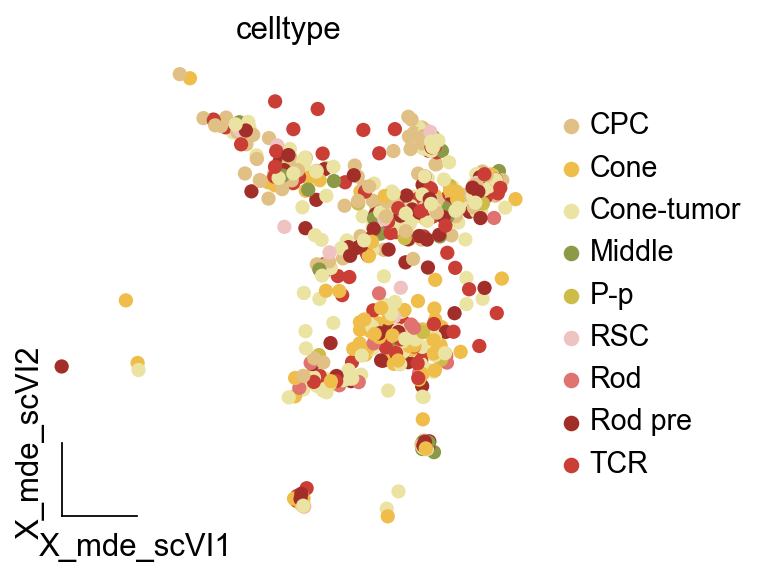

In [16]:
ov.utils.embedding(rb_rna,
                basis='X_mde_scVI',frameon='small',palette=ov.utils.orange_color[5:6]+ov.utils.orange_color[0:1]+ov.utils.orange_color[7:8]+ov.utils.orange_color[9:10]+ov.utils.orange_color[6:7]+ov.utils.red_color[:1]+ov.utils.red_color[1:2]+ov.utils.red_color[3:4]+ov.utils.red_color[2:3]+ov.utils.red_color[5:],
                color=['celltype'],show=False)

In [19]:
from scvi.model.utils import mde
rb_rna.obsm["X_mde_scVI"] = mde(rb_rna.obsm["X_scVI"])

In [21]:
sc.pp.neighbors(rb_rna, use_rep="X_scVI", metric="cosine",n_neighbors=10, random_state = 112)
sc.tl.leiden(rb_rna)
sc.tl.paga(rb_rna)
sc.pl.paga(rb_rna, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(rb_rna,init_pos='paga')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


<AxesSubplot: title={'center': 'leiden'}, xlabel='X_mde_scVI1', ylabel='X_mde_scVI2'>

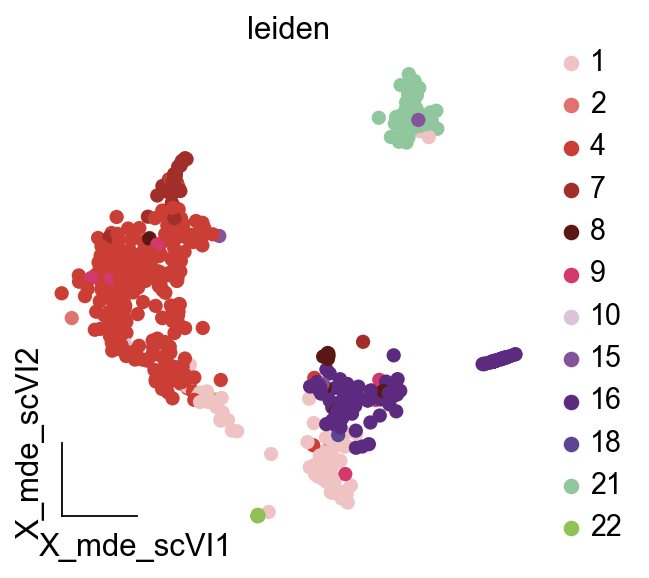

In [20]:
ov.utils.embedding(rb_rna,
                basis='X_mde_scVI',frameon='small',palette=ov.utils.red_color+ov.utils.green_color+ov.utils.orange_color,
                color=['leiden'],show=False)

In [22]:
small_marker_dict={
    'Rod': ['NRL','NR2E3','GNAT1','GRM8','PDC','CA2'],
    'Rod pre': ['CRX','RCVRN'],
    'Tumor cells':['HELLS','MCM3','PCNA'],
    'CPC':['ARR3','GUCA1A','RXRG'],
 'P-p':['APOLD1','ASMP','CENPF','GTSE1'],
'Middle':['EGFLAM','CAMK1D','ANKRD33B'],
    'TCR':['USPL1','ZFAS1'],
    'Cone': ['PDE6H','GUCA1C','ARR3','GNAT2','STXBP5L','MYO3A','GRM8'],
    'RSC':['TUBA1A','RBP1']
}
# check if the markers are in the data
smarker_genes_in_data = dict()
for ct, markers in small_marker_dict.items():
    markers_found = list()
    for marker in markers:
        if marker in rb_rna.raw.var_names:
            markers_found.append(marker)
    smarker_genes_in_data[ct] = markers_found
#del [] # remove the last marker
del_markers = list()
for ct, markers in smarker_genes_in_data.items():
    if markers==[]:
        del_markers.append(ct)
for ct in del_markers:
    del smarker_genes_in_data[ct]

Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: Rod, Rod pre, Tumor cells, etc.


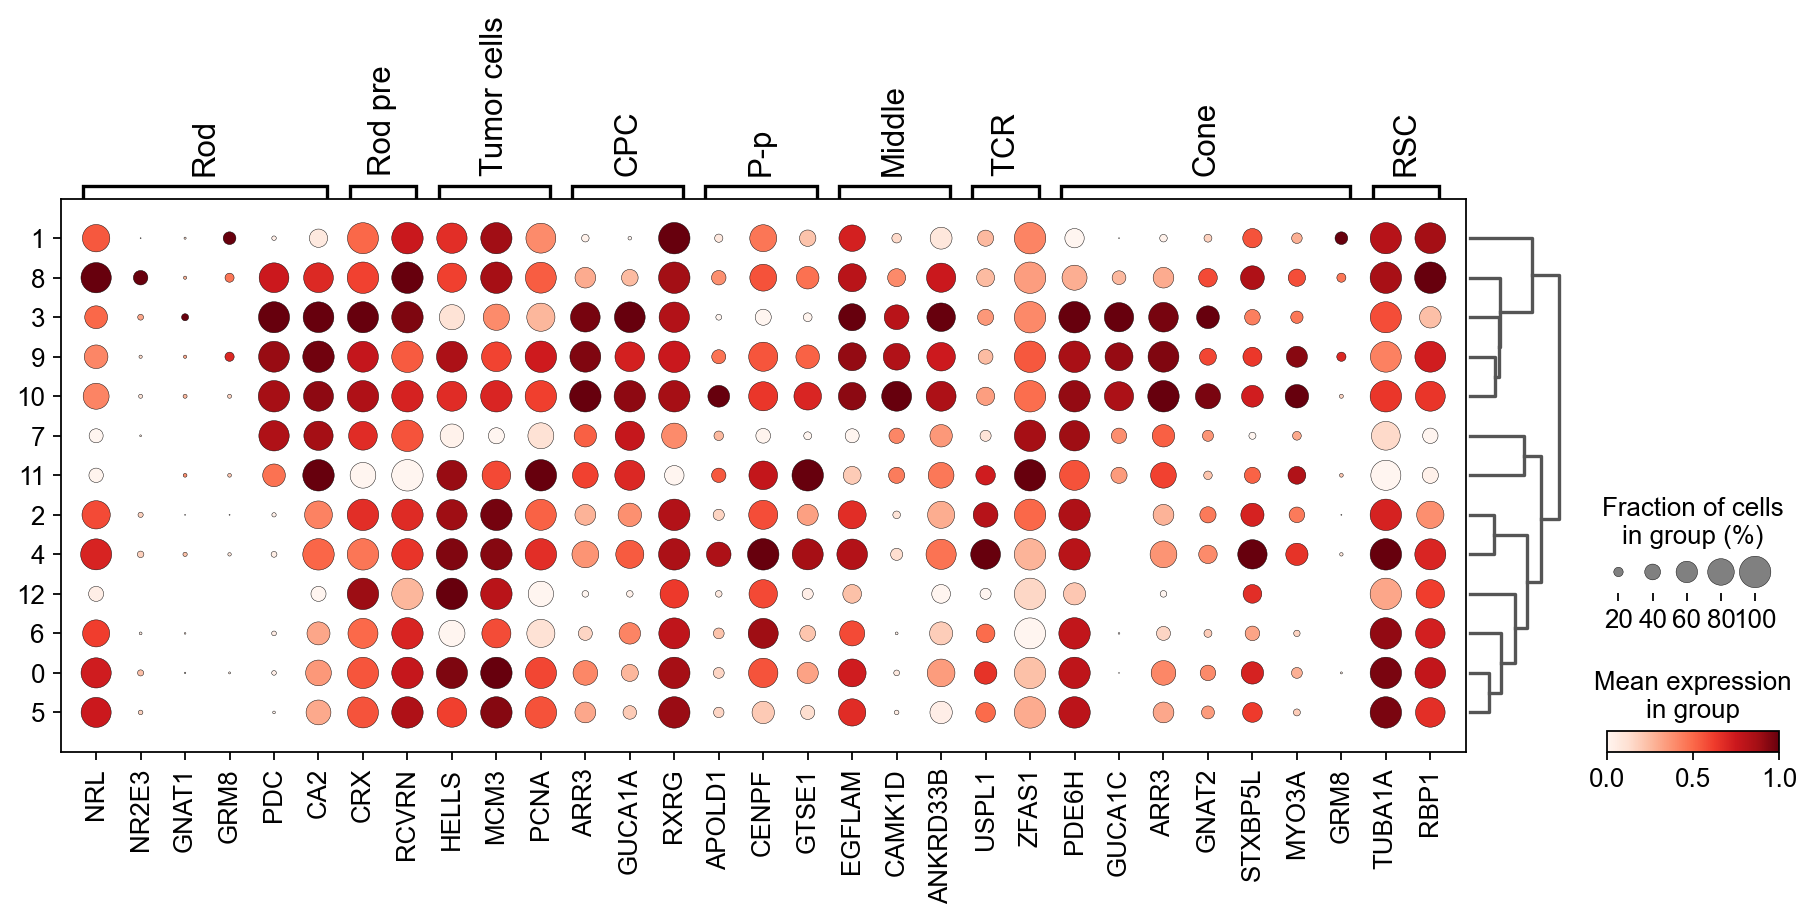

In [23]:
sc.tl.dendrogram(rb_rna,groupby='leiden',use_rep='X_scVI')
sc.pl.dotplot(
    rb_rna,
    groupby="leiden",
    var_names=smarker_genes_in_data,
    dendrogram=True,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
)

In [24]:
cluster2annotation = {
    '0': 'RSC',#1
    '1': 'Rod pre',#1
    '2': 'P-p',#1
    '3': 'CPC',#1
    '4': 'P-p',#1
    '5': 'RSC',#1
    '6': 'RSC',#1
    '7': 'Middle',#1
    '8': 'Rod',#1
    '9': 'Cone-tumor',#1
    '10': 'Cone',#1
    '11': 'TCR',#1
    '12':'RSC'
}
rb_rna.obs['celltype'] = rb_rna.obs['leiden'].map(cluster2annotation).astype('category')

In [10]:
rb_rna.write('/mnt/home/yihanzhao/RB/data_new/rb_rna.h5ad',compression='gzip')

In [10]:
rb_rna=sc.read_h5ad('/mnt/home/yihanzhao/RB/data_new/rb_rna.h5ad')

### atac-migra

In [11]:
rb_atac=sc.read_h5ad('/mnt/home/yihanzhao/RB/data_new/rb_atac.h5ad')

In [17]:
rb_atac.write('/mnt/home/yihanzhao/RB/data_new/rb_atac.h5ad',compression='gzip')

<AxesSubplot: title={'center': 'celltype'}, xlabel='X_mde_scVI1', ylabel='X_mde_scVI2'>

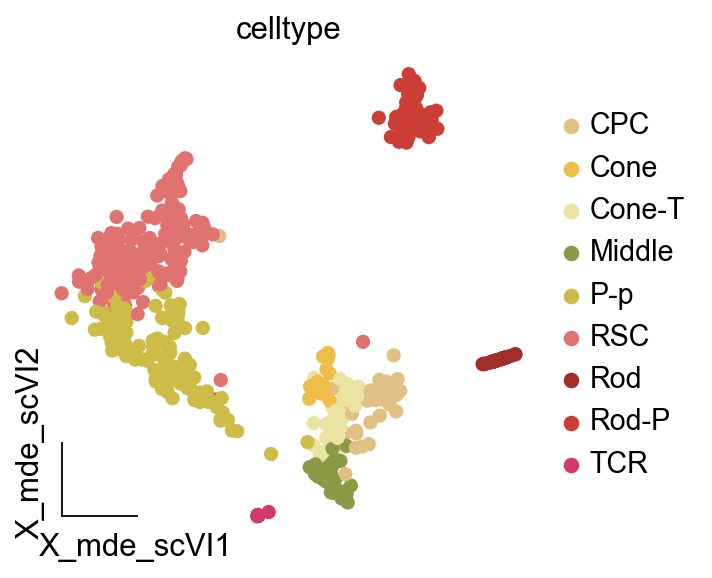

In [9]:
ov.utils.embedding(rb_rna,
                basis='X_mde_scVI',frameon='small',palette=ov.utils.orange_color[5:6]+ov.utils.orange_color[0:1]+ov.utils.orange_color[7:8]+ov.utils.orange_color[9:10]+ov.utils.orange_color[6:7]+ov.utils.red_color[1:2]+ov.utils.red_color[3:4]+ov.utils.red_color[2:3]+ov.utils.red_color[5:],
                color=['celltype'],show=False)

In [13]:
rb_atac.obs['celltype']=rb_rna.obs['celltype']

In [ ]:
pip install pymde

<AxesSubplot: title={'center': 'celltype'}, xlabel='X_mde_lsi1', ylabel='X_mde_lsi2'>

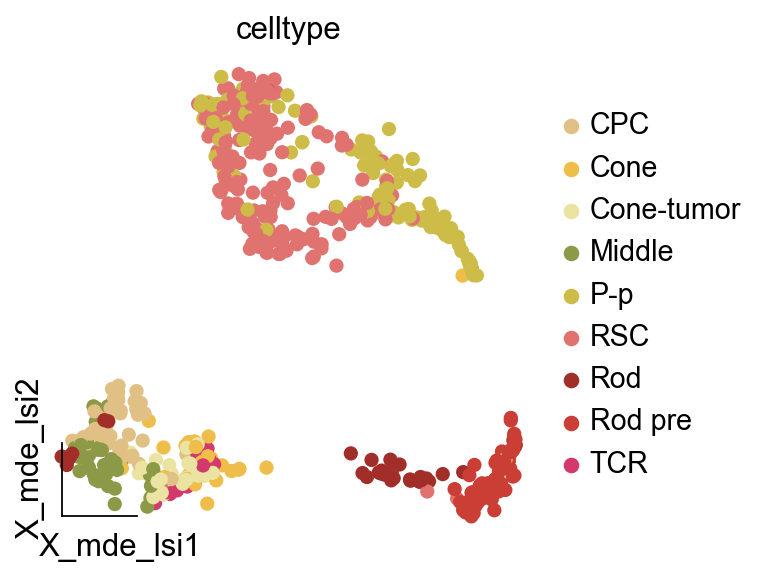

In [16]:
ov.utils.embedding(rb_atac,
                basis='X_mde_lsi',frameon='small',palette=ov.utils.orange_color[5:6]+ov.utils.orange_color[0:1]+ov.utils.orange_color[7:8]+ov.utils.orange_color[9:10]+ov.utils.orange_color[6:7]+ov.utils.red_color[1:2]+ov.utils.red_color[3:4]+ov.utils.red_color[2:3]+ov.utils.red_color[5:],
                color=['celltype'],show=False)

In [19]:
motif_rb=motif[motif.obs['tissue']=='rb']

In [20]:
motif_rb.obs['celltype']=rb_atac.obs['celltype']

In [21]:
sc.tl.rank_genes_groups(motif_rb, 'celltype', method='wilcoxon', use_raw=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [22]:
motif_rb.raw = motif_rb

In [23]:
motif_rb.obsm=rb_atac.obsm

In [25]:
import pandas as pd

In [26]:
pd.DataFrame(motif_rb.uns['rank_genes_groups']['names']).head(50)

,CPC,Cone,Cone-tumor,Middle,P-p,RSC,Rod,Rod pre,TCR
0,MA0139.1.CTCF,MA1513.1.KLF15,MA0131.2.HINFP,MA1650.1.ZBTB14,MA0648.1.GSC,MA1142.1.FOSL1::JUND,MA1620.1.Ptf1a(var.3),MA0095.2.YY1,MA1653.1.ZNF148
1,MA0131.2.HINFP,MA0506.1.NRF1,MA0506.1.NRF1,MA0740.1.KLF14,MA0891.1.GSC2,MA0490.2.JUNB,MA1621.1.Rbpjl,MA0748.2.YY2,MA1513.1.KLF15
2,MA1122.1.TFDP1,MA0131.2.HINFP,MA1122.1.TFDP1,MA0497.1.MEF2C,MA0883.1.Dmbx1,MA0491.2.JUND,MA1649.1.ZBTB12,MA1589.1.ZNF140,MA0025.2.NFIL3
3,MA0740.1.KLF14,MA0846.1.FOXC2,MA1650.1.ZBTB14,MA1516.1.KLF3,MA0714.1.PITX3,MA1128.1.FOSL1::JUN,MA1651.1.ZFP42,MA0496.3.MAFK,MA1122.1.TFDP1
4,MA1516.1.KLF3,MA1650.1.ZBTB14,MA0632.2.TCFL5,MA1515.1.KLF2,MA0712.2.OTX2,MA1130.1.FOSL2::JUN,MA1643.1.NFIB,MA0728.1.Nr2f6(var.2),MA0785.1.POU2F1
5,MA0506.1.NRF1,MA0851.1.Foxj3,MA1513.1.KLF15,MA0052.4.MEF2A,MA0682.2.PITX1,MA0477.2.FOSL1,MA1565.1.TBX18,MA0884.1.DUXA,MA0865.1.E2F8
6,MA0812.1.TFAP2B(var.2),MA0815.1.TFAP2C(var.3),MA0162.4.EGR1,MA0822.1.HES7,MA1480.1.DPRX,MA0099.3.FOS::JUN,MA0065.2.Pparg::Rxra,MA0828.1.SREBF2(var.2),MA0885.1.Dlx2
7,MA1650.1.ZBTB14,MA0813.1.TFAP2B(var.3),MA0647.1.GRHL1,MA1513.1.KLF15,MA1547.1.PITX2,MA0478.1.FOSL2,MA0139.1.CTCF,MA0829.2.SREBF1(var.2),MA0696.1.ZIC1
8,MA0738.1.HIC2,MA0629.1.Rhox11,MA0471.2.E2F6,MA0506.1.NRF1,MA0461.2.Atoh1,MA1134.1.FOS::JUNB,MA1523.1.MSANTD3,MA0093.3.USF1,MA0442.2.SOX10
9,MA1581.1.ZBTB6,MA0052.4.MEF2A,MA1569.1.TFAP2E,MA0773.1.MEF2D,MA0467.1.Crx,MA1144.1.FOSL2::JUND,MA0517.1.STAT1::STAT2,MA0526.3.USF2,MA0618.1.LBX1


In [46]:
motif_rb2 = motif_rb[motif_rb.obs['celltype']!='CPC']
motif_rb2 = motif_rb2[motif_rb2.obs['celltype']!='Middle']
motif_rb2 = motif_rb2[motif_rb2.obs['celltype']!='RSC']
motif_rb2 = motif_rb2[motif_rb2.obs['celltype']!='Rod']
motif_rb2 = motif_rb2[motif_rb2.obs['celltype']!='Rod pre']
motif_rb2 = motif_rb2[motif_rb2.obs['celltype']!='TCR']

In [47]:
motif_rb2.raw = motif_rb2

In [48]:
sc.tl.rank_genes_groups(motif_rb2, 'celltype', method='wilcoxon', use_raw=True)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [49]:
motif_rb.obsm=rb_atac.obsm

<AxesSubplot: title={'center': 'celltype'}, xlabel='X_mde_lsi1', ylabel='X_mde_lsi2'>

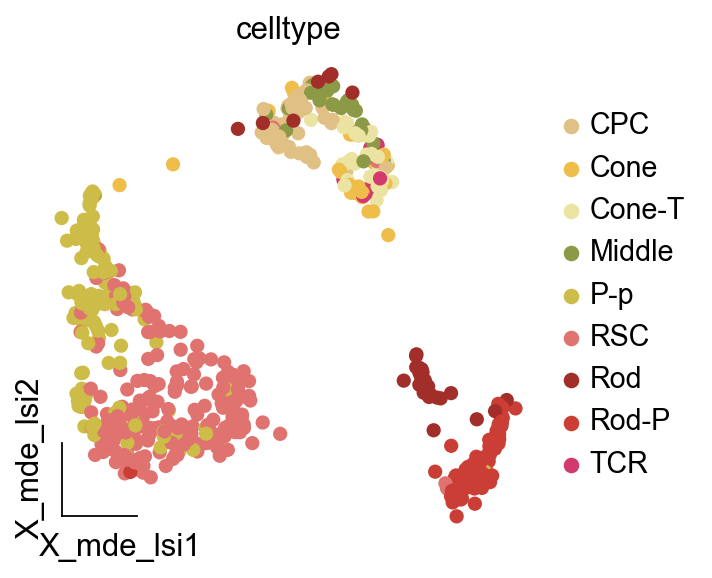

In [16]:
ov.utils.embedding(rb_atac,
                basis='X_mde_lsi',frameon='small',palette=ov.utils.orange_color[5:6]+ov.utils.orange_color[0:1]+ov.utils.orange_color[7:8]+ov.utils.orange_color[9:10]+ov.utils.orange_color[6:7]+ov.utils.red_color[1:2]+ov.utils.red_color[3:4]+ov.utils.red_color[2:3]+ov.utils.red_color[5:],
                color=['celltype'],show=False)

<AxesSubplot: title={'center': 'celltype'}, xlabel='X_mde_scVI1', ylabel='X_mde_scVI2'>

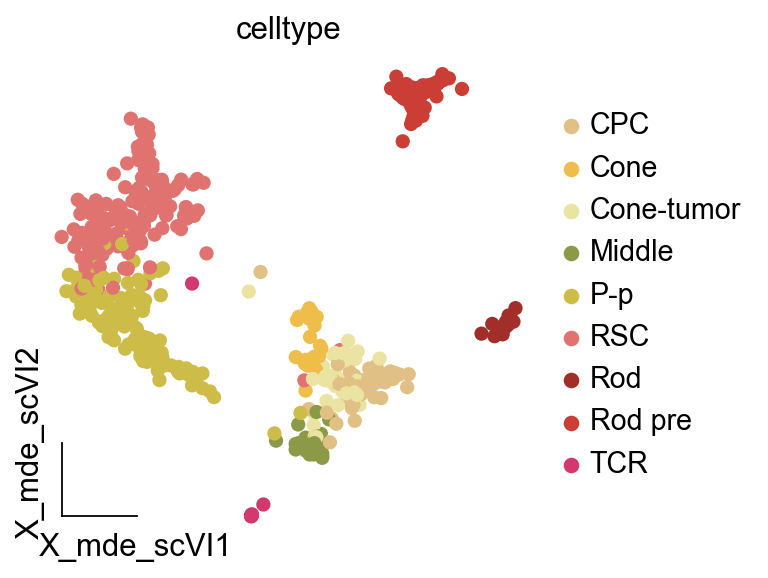

In [208]:
ov.utils.embedding(rb_rna,
                basis='X_mde_scVI',frameon='small',palette=ov.utils.orange_color[5:6]+ov.utils.orange_color[0:1]+ov.utils.orange_color[7:8]+ov.utils.orange_color[9:10]+ov.utils.orange_color[6:7]+ov.utils.red_color[1:2]+ov.utils.red_color[3:4]+ov.utils.red_color[2:3]+ov.utils.red_color[5:],
                color=['celltype'],show=False)

In [69]:
rb_rna

AnnData object with n_obs × n_vars = 729 × 16801
    obs: 'tissue', 'domain', 'sample', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'leiden', 'celltype', 'balancing_weight'
    var: 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
    uns: 'celltype_colors', 'leiden_colors', 'neighbors', 'leiden', 'paga', 'leiden_sizes', 'umap', 'dendrogram_leiden'
    obsm: 'X_glue', 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'X_umap', 'scaled|original|X_pca'
    varm: 'scaled|original|pca_loadings'
    layers: 'counts', 'lognorm', 'scaled'
    obsp: 'distances', 'connectivities'

In [397]:
pd.DataFrame(motif_rb2.uns['rank_genes_groups']['names']).head(50)

,Cone,Cone-tumor,P-p
0,MA0846.1.FOXC2,MA0131.2.HINFP,MA1642.1.NEUROG2(var.2)
1,MA1513.1.KLF15,MA0506.1.NRF1,MA1109.1.NEUROD1
2,MA0813.1.TFAP2B(var.3),MA0647.1.GRHL1,MA0091.1.TAL1::TCF3
3,MA0032.2.FOXC1,MA1650.1.ZBTB14,MA1618.1.Ptf1a
4,MA0851.1.Foxj3,MA1122.1.TFDP1,MA0669.1.NEUROG2
5,MA0506.1.NRF1,MA0139.1.CTCF,MA1638.1.HAND2
6,MA1471.1.BARX2,MA1513.1.KLF15,MA1568.1.TCF21(var.2)
7,MA0815.1.TFAP2C(var.3),MA0471.2.E2F6,MA1604.1.Ebf2
8,MA0052.4.MEF2A,MA0162.4.EGR1,MA0668.1.NEUROD2
9,MA0131.2.HINFP,MA0632.2.TCFL5,MA1468.1.ATOH7


## P-p

<AxesSubplot: title={'center': 'MA0154.4.EBF1'}, xlabel='X_mde_lsi1', ylabel='X_mde_lsi2'>

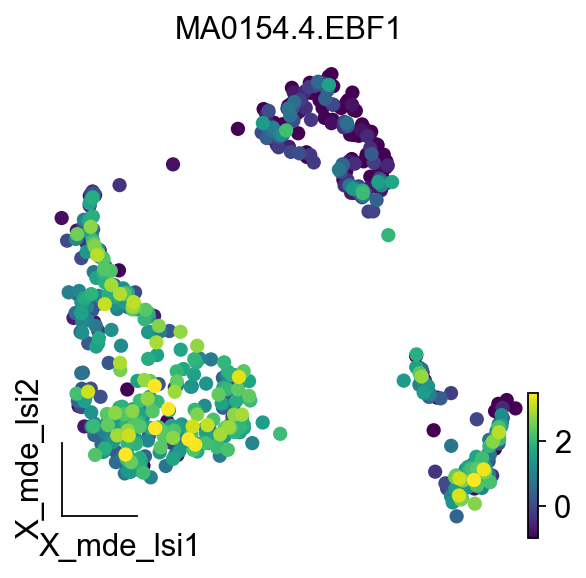

In [78]:
ov.utils.embedding(motif_rb,
                basis='X_mde_lsi',frameon='small',palette=ov.utils.orange_color[5:6]+ov.utils.orange_color[0:1]+ov.utils.orange_color[7:8]+ov.utils.orange_color[9:10]+ov.utils.orange_color[6:7]+ov.utils.red_color[:1]+ov.utils.red_color[1:2]+ov.utils.red_color[3:4]+ov.utils.red_color[2:3]+ov.utils.red_color[5:],
                color=['MA0154.4.EBF1'],show=False,vmax=3.5,vmin=-1)

<AxesSubplot: title={'center': 'EBF1'}, xlabel='X_mde_scVI1', ylabel='X_mde_scVI2'>

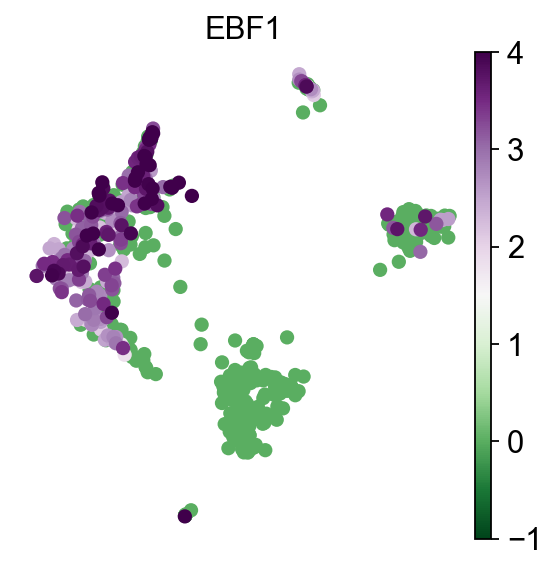

In [81]:
gene='EBF1'
sc.pl.embedding(
        rb_rna,
        basis="X_mde_scVI",
        color=[gene],
        title='EBF1',
        frameon=False,
        ncols=3,
        #return_fig=True,
        wspace=0.5,
        show=False,
        cmap="PRGn_r",
        vmin=-1,
        vmax=4,
        #palette=sc_color[11:],
    )

## Cone

<AxesSubplot: title={'center': 'MA1152.1.SOX15'}, xlabel='X_mde_lsi1', ylabel='X_mde_lsi2'>

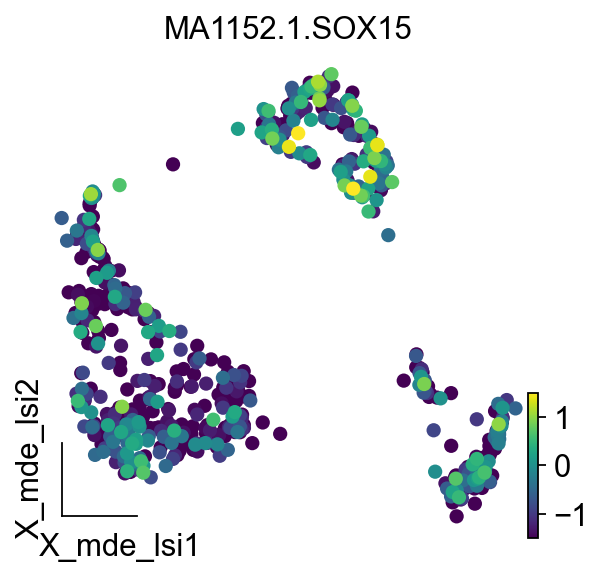

In [67]:
ov.utils.embedding(motif_rb,
                basis='X_mde_lsi',frameon='small',palette=ov.utils.orange_color[5:6]+ov.utils.orange_color[0:1]+ov.utils.orange_color[7:8]+ov.utils.orange_color[9:10]+ov.utils.orange_color[6:7]+ov.utils.red_color[:1]+ov.utils.red_color[1:2]+ov.utils.red_color[3:4]+ov.utils.red_color[2:3]+ov.utils.red_color[5:],
                color=['MA1152.1.SOX15'],show=False,vmax=1.5,vmin=-1.5)

<AxesSubplot: title={'center': 'SOX15'}, xlabel='X_mde_scVI1', ylabel='X_mde_scVI2'>

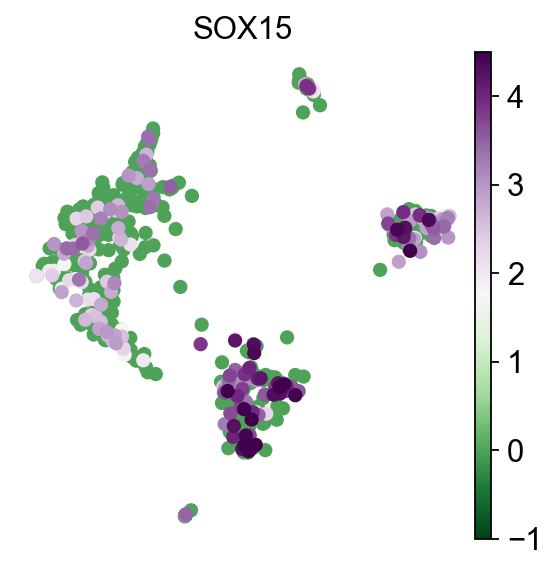

In [87]:
gene='SOX15'
sc.pl.embedding(
        rb_rna,
        basis="X_mde_scVI",
        color=[gene],
        title='SOX15',
        frameon=False,
        ncols=3,
        #return_fig=True,
        wspace=0.5,
        show=False,
        cmap="PRGn_r",
        vmin=-1,
        vmax=4.5,
        #palette=sc_color[11:],
    )

## Cone-tumor

<AxesSubplot: title={'center': 'MA0025.2.NFIL3'}, xlabel='X_mde_lsi1', ylabel='X_mde_lsi2'>

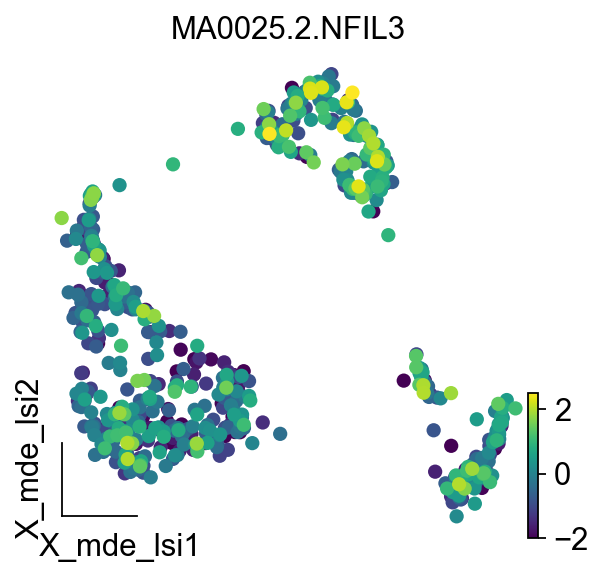

In [93]:
ov.utils.embedding(motif_rb,
                basis='X_mde_lsi',frameon='small',palette=ov.utils.orange_color[5:6]+ov.utils.orange_color[0:1]+ov.utils.orange_color[7:8]+ov.utils.orange_color[9:10]+ov.utils.orange_color[6:7]+ov.utils.red_color[:1]+ov.utils.red_color[1:2]+ov.utils.red_color[3:4]+ov.utils.red_color[2:3]+ov.utils.red_color[5:],
                color=['MA0025.2.NFIL3'],show=False,vmax=2.5,vmin=-2)

<AxesSubplot: title={'center': 'NFIL3'}, xlabel='X_mde_scVI1', ylabel='X_mde_scVI2'>

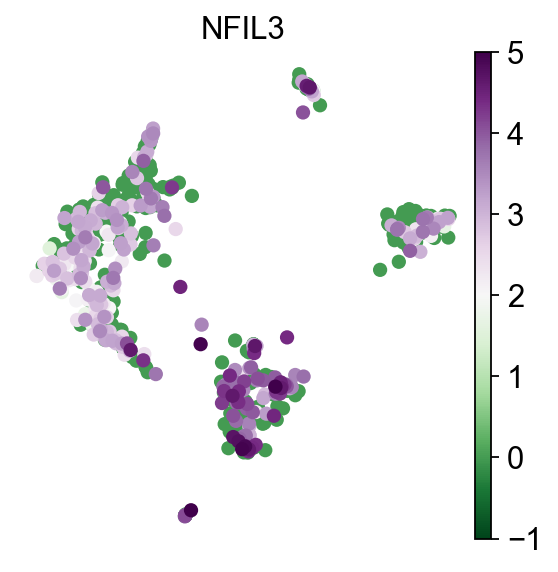

In [100]:
gene='NFIL3'
sc.pl.embedding(
        rb_rna,
        basis="X_mde_scVI",
        color=[gene],
        title='NFIL3',
        frameon=False,
        ncols=3,
        #return_fig=True,
        wspace=0.5,
        show=False,
        cmap="PRGn_r",
        vmin=-1,
        vmax=5,
        #palette=sc_color[11:],
    )

## chrom

In [ ]:
import Epiverse as ev

In [7]:
rb_atac

AnnData object with n_obs × n_vars = 729 × 150000
    obs: 'sample', 'tissue', 'domain', 'week', 'balancing_weight', 'celltype'
    var: 'chrom', 'chromStart', 'chromEnd', 'highly_variable', 'seqnames', 'start', 'end'
    uns: 'celltype_colors'
    obsm: 'X_glue', 'X_lsi', 'X_mde_lsi', 'X_umap'

In [8]:
# Get chromosome sizes (for hg38 here)
import pyranges as pr
import requests
import pandas as pd
target_url = '/mnt/home/yihanzhao/RB/data_new/hg38.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)

In [9]:
rb_atac.obs['celltype'].cat.categories.tolist()

['CPC', 'Cone', 'Cone-tumor', 'Middle', 'P-p', 'RSC', 'Rod', 'Rod pre', 'TCR']

In [10]:
#!mkdir result/pseudobulk_bw_files
ev.single.pseudobulk(rb_atac,chromsizes,cluster_key='celltype',size=1000,
           clusters=rb_atac.obs['celltype'].cat.categories.tolist(),
           chr=['seqnames','start','end'],
           bigwig_path='temp')

['CPC', 'Cone', 'Cone-tumor', 'Middle', 'P-p', 'RSC', 'Rod', 'Rod pre', 'TCR']


  0%|                                                                    | 0/9 [00:00<?, ?it/s]

CPC chr_value
CPC chr_start
CPC chr_end
CPC Name
CPC Score
CPC write


 11%|██████▋                                                     | 1/9 [00:07<01:00,  7.56s/it]

Cone chr_value
Cone chr_start
Cone chr_end
Cone Name
Cone Score
Cone write


 22%|█████████████▎                                              | 2/9 [00:11<00:39,  5.60s/it]

Cone-tumor chr_value
Cone-tumor chr_start
Cone-tumor chr_end
Cone-tumor Name
Cone-tumor Score
Cone-tumor write


 33%|████████████████████                                        | 3/9 [00:16<00:32,  5.38s/it]

Middle chr_value
Middle chr_start
Middle chr_end
Middle Name
Middle Score
Middle write


 44%|██████████████████████████▋                                 | 4/9 [00:22<00:26,  5.38s/it]

P-p chr_value
P-p chr_start
P-p chr_end
P-p Name
P-p Score
P-p write


 56%|█████████████████████████████████▎                          | 5/9 [00:38<00:36,  9.12s/it]

RSC chr_value
RSC chr_start
RSC chr_end
RSC Name
RSC Score
RSC write


 67%|████████████████████████████████████████                    | 6/9 [01:00<00:40, 13.55s/it]

Rod chr_value
Rod chr_start
Rod chr_end
Rod Name
Rod Score
Rod write


 78%|██████████████████████████████████████████████▋             | 7/9 [01:05<00:21, 10.83s/it]

Rod pre chr_value
Rod pre chr_start
Rod pre chr_end
Rod pre Name
Rod pre Score
Rod pre write


 89%|█████████████████████████████████████████████████████▎      | 8/9 [01:16<00:10, 10.97s/it]

TCR chr_value
TCR chr_start
TCR chr_end
TCR Name
TCR Score
TCR write


100%|████████████████████████████████████████████████████████████| 9/9 [01:19<00:00,  8.83s/it]


In [13]:
bw_dict=dict(zip(rb_atac.obs['celltype'].cat.categories.tolist(),
                 [f'temp/{i}.bw' for i in rb_atac.obs['celltype'].cat.categories]))
bw_obj=ev.bulk.bigwig(bw_dict)
bw_obj.read()

......Loading CPC
......Loading Cone
......Loading Cone-tumor
......Loading Middle
......Loading P-p
......Loading RSC
......Loading Rod
......Loading Rod pre
......Loading TCR


In [29]:
bw_obj.load_gtf('/mnt/home/zehuazeng/data/gtf/gencode.v43.basic.annotation.gtf')

......Loading gtf file


In [32]:
color_dict=dict(zip(rb_atac.obs['celltype'].cat.categories,rb_atac.uns['celltype_colors']))

## P-p

In [26]:
rna.var.loc['EBF1',['chrom','chromStart','chromEnd']]

chrom              chr5
chromStart    158695919
chromEnd      159099916
Name: EBF1, dtype: object

In [30]:
region_dict={
    'region1':[158695919, 159099916],
}

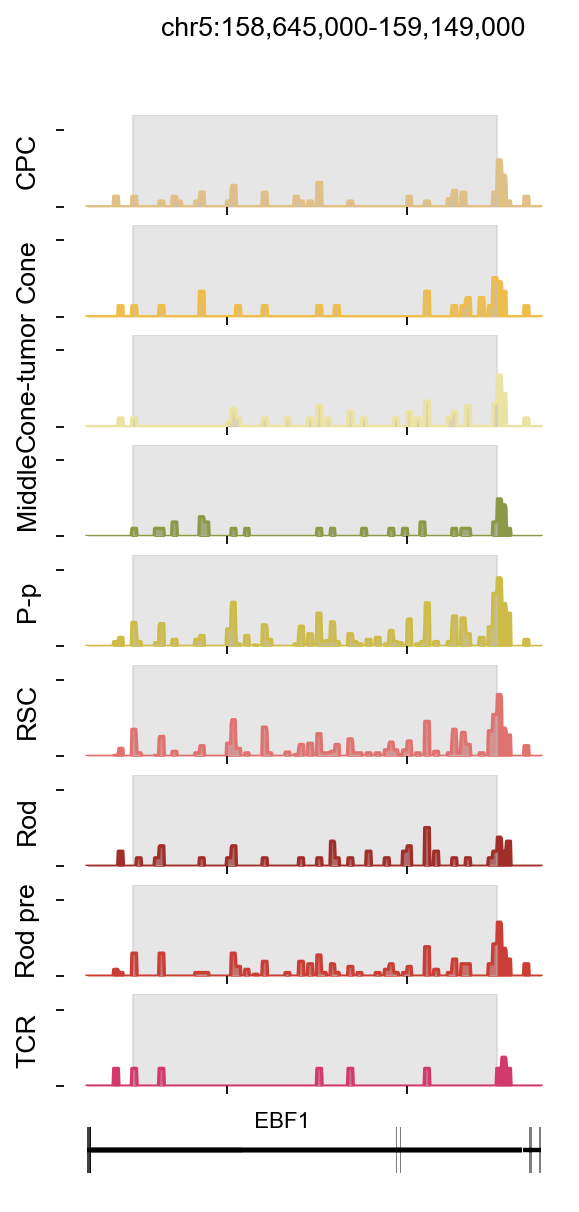

In [50]:
import matplotlib.pyplot as plt
#TCF4: chr18：55,222,185-55,635,957
fig,axes=bw_obj.plot_track(chrom='chr5',chromstart=158695000-50000,chromend=159099000+50000,
                  plot_names=rb_atac.obs['celltype'].cat.categories.tolist(),
                           transform='log1p',
                           gtf_color='#000000',
                figwidth=4,figheight=8.0,
                  color_dict=color_dict,
                  region_dict=region_dict,
                  jump_symbols=['ENSG','LINC'],prefered_name='gene_name',
                           ymax=3,text_fontsize=10
                 )

## Cone

In [51]:
rna.var.loc['SOX15',['chrom','chromStart','chromEnd']]

chrom           chr17
chromStart    7588177
chromEnd      7590094
Name: SOX15, dtype: object

In [52]:
region_dict={
    'region1':[7588177, 7590094],
}

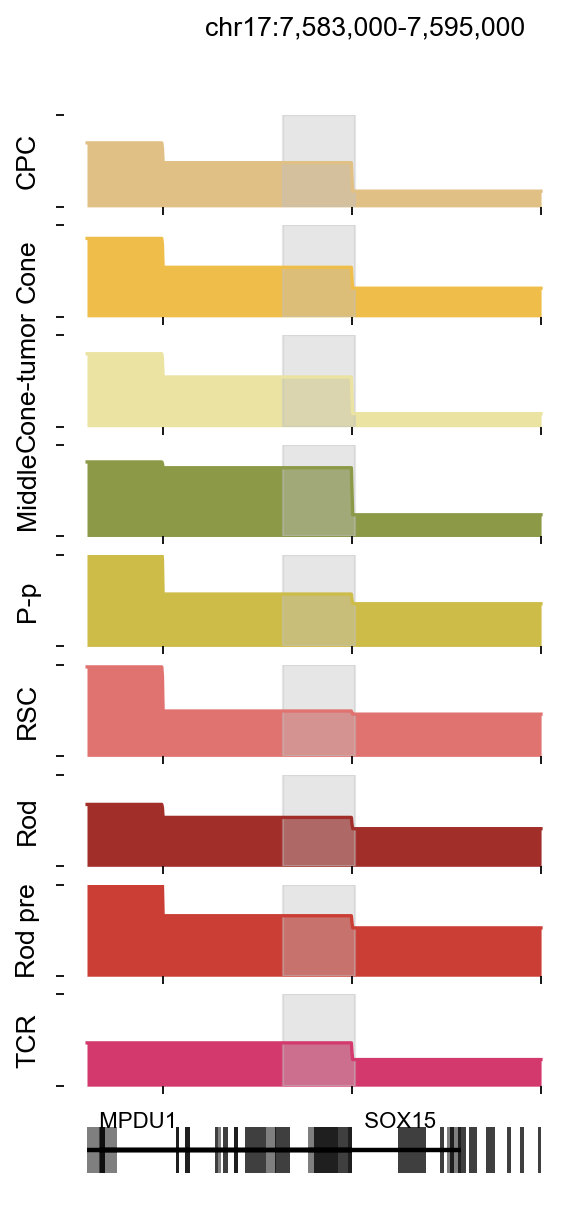

In [59]:
import matplotlib.pyplot as plt
fig,axes=bw_obj.plot_track(chrom='chr17',chromstart=7588000-5000,chromend=7590000+5000,
                  plot_names=rb_atac.obs['celltype'].cat.categories.tolist(),
                           transform='log1p',
                           gtf_color='#000000',
                figwidth=4,figheight=8.0,
                  color_dict=color_dict,
                  region_dict=region_dict,
                  jump_symbols=['ENSG','LINC'],prefered_name='gene_name',
                           ymax=2,text_fontsize=10
                 )

## Cone-tumor

In [60]:
rna.var.loc['NFIL3',['chrom','chromStart','chromEnd']]

chrom             chr9
chromStart    91409044
chromEnd      91423832
Name: NFIL3, dtype: object

In [61]:
region_dict={
    'region1':[91409044, 91423832],
}

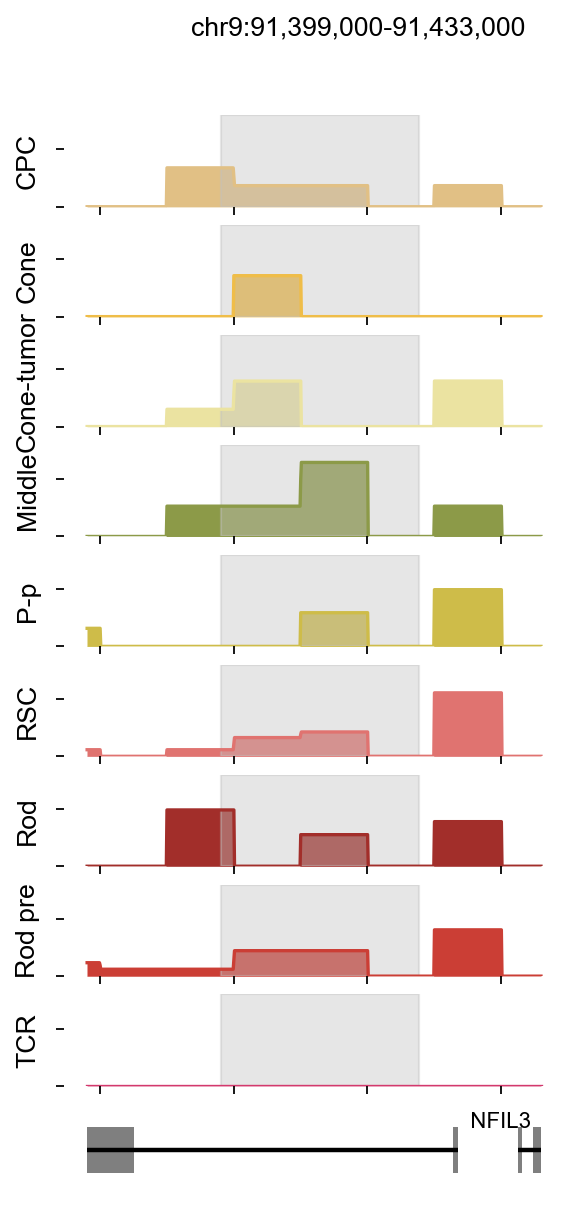

In [68]:
import matplotlib.pyplot as plt
fig,axes=bw_obj.plot_track(chrom='chr9',chromstart=91409000-10000,chromend=91423000+10000,
                  plot_names=rb_atac.obs['celltype'].cat.categories.tolist(),
                           transform='log1p',
                           gtf_color='#000000',
                figwidth=4,figheight=8.0,
                  color_dict=color_dict,
                  region_dict=region_dict,
                  jump_symbols=['ENSG','LINC'],prefered_name='gene_name',
                           ymax=0.8,text_fontsize=10
                 )

## venn

In [6]:
motif.var['gene']=motif.var.index

In [9]:
motif.var

,gene
MA0004.1.Arnt,ARNT
MA0006.1.Ahr::Arnt,AHR::ARNT
MA0019.1.Ddit3::Cebpa,DDIT3::CEBPA
MA0029.1.Mecom,MECOM
MA0030.1.FOXF2,FOXF2
...,...
MA0093.3.USF1,USF1
MA0526.3.USF2,USF2
MA0748.2.YY2,YY2
MA0528.2.ZNF263,ZNF263


In [13]:
motif.var

,gene
MA0004.1.Arnt,ARNT
MA0006.1.Ahr::Arnt,AHR::ARNT
MA0019.1.Ddit3::Cebpa,DDIT3::CEBPA
MA0029.1.Mecom,MECOM
MA0030.1.FOXF2,FOXF2
...,...
MA0093.3.USF1,USF1
MA0526.3.USF2,USF2
MA0748.2.YY2,YY2
MA0528.2.ZNF263,ZNF263


In [8]:
motif.var['gene'] = motif.var['gene'].str.split('.').str[-1].str.upper()

In [13]:
ret_motif=list(motif.var['gene'])
ret_motif

['ARNT',
 'AHR::ARNT',
 'DDIT3::CEBPA',
 'MECOM',
 'FOXF2',
 'FOXD1',
 'FOXQ1',
 'FOXD3',
 'IRF2',
 '2)',
 'MAX::MYC',
 'PPARG',
 'PAX2',
 'PAX6',
 'PBX1',
 'RORA',
 '2)',
 'RREB1',
 'RXRA::VDR',
 'SOX9',
 'SOX17',
 'SRY',
 'SOX5',
 'TAL1::TCF3',
 'HAND1::TCF3',
 'REL',
 'RELA',
 'TBP',
 'HLTF',
 'SPZ1',
 'NR1H2::RXRA',
 'ZNF423',
 'NFIC::TLX1',
 'NOBOX',
 'ZNF354C',
 'LHX3',
 'CTCF',
 'POU5F1::SOX2',
 'EWSR1-FLI1',
 'REST',
 'RUNX1',
 'PPARG::RXRA',
 'ARID3A',
 'NFATC2',
 'INSM1',
 'RARA::RXRA',
 'NR4A2',
 'PLAG1',
 'NR2E3',
 'ARNT::HIF1A',
 'ZFX',
 'ZBTB33',
 'TCF7L2',
 'TCF12',
 'STAT6',
 'STAT5A::STAT5B',
 'CRX',
 'DUX4',
 'FOS',
 'FOSL2',
 'FOXH1',
 'FOXO1',
 'GFI1B',
 'JUN',
 '2)',
 '2)',
 'KLF1',
 'NR1H3::RXRA',
 'MEF2C',
 'MAF::NFE2',
 '2)',
 'NR2C2',
 'NR5A2',
 'NRF1',
 'POU2F2',
 'SMAD2::SMAD3::SMAD4',
 'SOX3',
 'SOX6',
 'STAT1::STAT2',
 'STAT4',
 'ELK4',
 'ESR2',
 'IRF1',
 'NFE2L2',
 'STAT1',
 'STAT3',
 'GATA1::TAL1',
 'YY1',
 'BACH1::MAFK',
 'FOXP2',
 'SREBF1',
 'SREBF2',
 

In [15]:
rna=rb_rna

In [19]:
ret_gene=list(rna.var.index)
ret_gene

['ISG15',
 'TNFRSF18',
 'TNFRSF4',
 'MMP23B',
 'HES5',
 'TNFRSF14',
 'ACTRT2',
 'CCDC27',
 'RPL22',
 'ESPN',
 'ENO1',
 'SLC2A5',
 'RBP7',
 'TNFRSF1B',
 'DHRS3',
 'PDPN',
 'HSPB7',
 'MFAP2',
 'PLA2G2A',
 'PLA2G5',
 'CDA',
 'HP1BP3',
 'HSPG2',
 'C1QA',
 'C1QC',
 'C1QB',
 'TCEA3',
 'ID3',
 'RPL11',
 'LDLRAP1',
 'STMN1',
 'SH3BGRL3',
 'CD52',
 'HMGN2',
 'SFN',
 'TRNP1',
 'FGR',
 'IFI6',
 'THEMIS2',
 'PTAFR',
 'MED18',
 'SNHG12',
 'RAB42',
 'TMEM200B',
 'LAPTM5',
 'LCK',
 'MARCKSL1',
 'SFPQ',
 'CLSPN',
 'COL8A2',
 'EVA1B',
 'CSF3R',
 'CDCA8',
 'RHBDL2',
 'YBX1',
 'TIE1',
 'CDC20',
 'KIF2C',
 'RPS8',
 'PRDX1',
 'UQCRH',
 'ELAVL4',
 'PODN',
 'PLPP3',
 'FYB2',
 'TACSTD2',
 'JUN',
 'NFIA',
 'L1TD1',
 'FOXD3',
 'GADD45A',
 'RPE65',
 'DEPDC1',
 'ST6GALNAC5',
 'NEXN',
 'IFI44L',
 'IFI44',
 'ADGRL4',
 'GNG5',
 'COL24A1',
 'GBP1',
 'GBP2',
 'GBP5',
 'BTBD8',
 'RPL5',
 'F3',
 'PALMD',
 'FRRS1',
 'AGL',
 'VCAM1',
 'S1PR1',
 'COL11A1',
 'GSTM5',
 'UBL4B',
 'CD53',
 'CHI3L2',
 'C1orf162',
 'OLFML3',
 'S

In [20]:
set_motif = set(ret_motif)
set_gene = set(ret_gene)

In [18]:
%%time
rna.raw = rna
rna = rna[:, rna.var.highly_variable_features]
rna

CPU times: user 30.7 ms, sys: 10.9 ms, total: 41.6 ms
Wall time: 45.8 ms


View of AnnData object with n_obs × n_vars = 729 × 1875
    obs: 'tissue', 'domain', 'sample', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'leiden', 'celltype', 'balancing_weight'
    var: 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
    uns: 'celltype_colors', 'dendrogram_leiden', 'leiden', 'leiden_sizes', 'neighbors', 'paga', 'umap'
    obsm: 'X_glue', 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'X_umap', 'scaled|original|X_pca'
    varm: 'scaled|original|pca_loadings'
    layers: 'counts', 'lognorm', 'scaled'
    obsp: 'connectivities', 'distances'

In [25]:
pip install matplotlib-venn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 62.9 kB/s eta 0:00:0031m6.7 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for matplotlib-venn: filename=matplotlib_venn-1.1.1-py3-none-any.whl size=45286 sha256=415ee70eb3e49158e3ba95b3d6982d0cfacf3cbcddaf07798e345bb7422546dc
  Stored in directory: /mnt/home/yihanzhao/.cache/pip/wheels/3c/b6/e2/5fadaf4aa63fac5b079d4f633e9d96b29a67ee4fae816806f3
Successfully built matplotlib-venn
Note: you may need to restart the kernel to use updated packages.


In [26]:
from matplotlib_venn import venn2, venn2_circles
import matplotlib.pyplot as plt

(<matplotlib.patches.Circle at 0x7f3083768df0>,
 <matplotlib.patches.Circle at 0x7f3083768e50>)

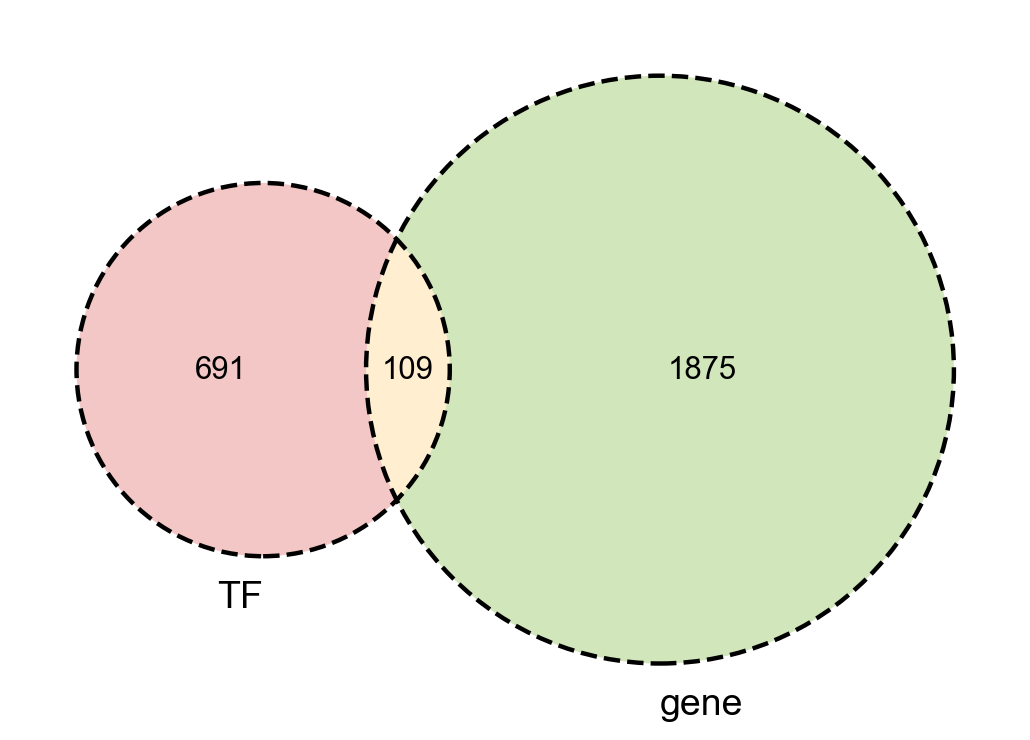

In [27]:
intersection = set_motif & set_gene
size_motif = len(set_motif)
size_gene = len(set_gene)
size_intersection = len(intersection)
plt.figure(figsize=(8, 8))

v = venn2(subsets=(size_motif, size_gene, size_intersection), 
          set_labels=('TF', 'gene'),
          set_colors=(ov.pl.red_color[1],ov.pl.green_color[1]))

venn2_circles(subsets=(size_motif, size_gene, size_intersection),
              linestyle='--', linewidth=2, color="black")

## EBF1-GSEA

In [3]:
import pandas as pd

In [140]:
df = pd.read_csv('/mnt/home/yihanzhao/RB/data_new/TF-gene/EBF1.csv')

In [20]:
gene_list=['PNPLA7','SLC18A3','FEM1A','DMPK','OASL','FMNL1','CENPF','GTSE1']

In [76]:
pathway_dict=ov.utils.geneset_prepare('/mnt/home/zehuazeng/analysis/placenta/genesets/WikiPathway_2021_Human.txt',organism='Human')
#pathway_dict=ov.utils.geneset_prepare('/mnt/home/zehuazeng/analysis/placenta/genesets/GO_Biological_Process_2023.txt',organism='Human')

In [141]:
enr=ov.bulk.geneset_enrichment(gene_list=list(df['target_genes']),
                                pathways_dict=pathway_dict,
                                pvalue_type='normal',
                                organism='Human')

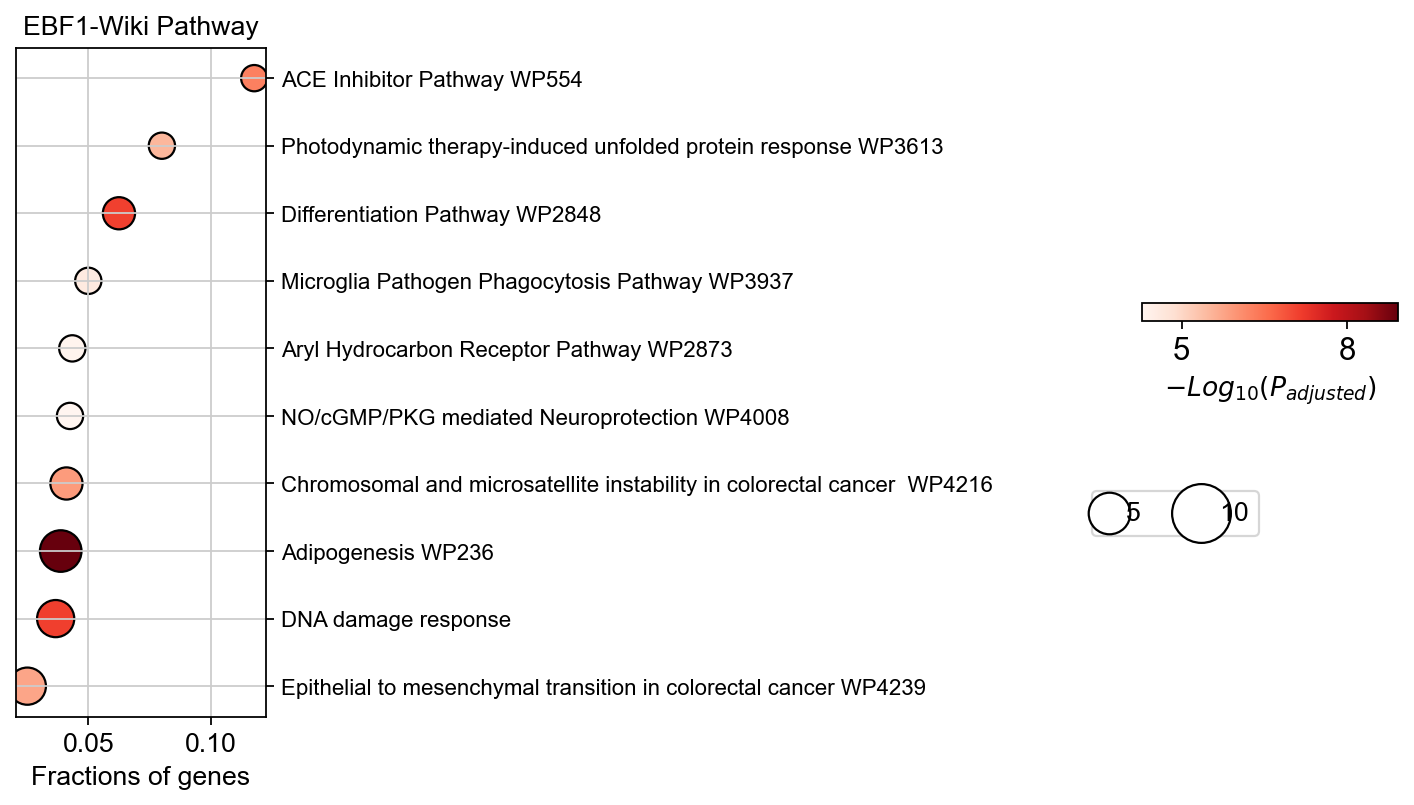

In [142]:
ax=ov.bulk.geneset_plot(enr,figsize=(2,5.5),fig_title='EBF1-Wiki Pathway',
                    cax_loc=[3.7, 0.6, 0.8, 0.02],
                    bbox_to_anchor_used=(-0.25, -13),node_diameter=70,
                    cmap='Reds',custom_ticks=[5,8],text_knock=200,node_size=[5,10])
plt.grid(False)
plt.savefig('/mnt/home/yihanzhao/RB/fig3/EBF1-gsea',dpi=300,bbox_inches='tight')

## SOX15-GSEA

In [136]:
df2 = pd.read_csv('/mnt/home/yihanzhao/RB/data_new/TF-gene/TF_SOX15_target_genes(1).csv')

In [137]:
enr=ov.bulk.geneset_enrichment(gene_list=list(df2['target_genes']),
                                pathways_dict=pathway_dict,
                                pvalue_type='normal',
                                organism='human')

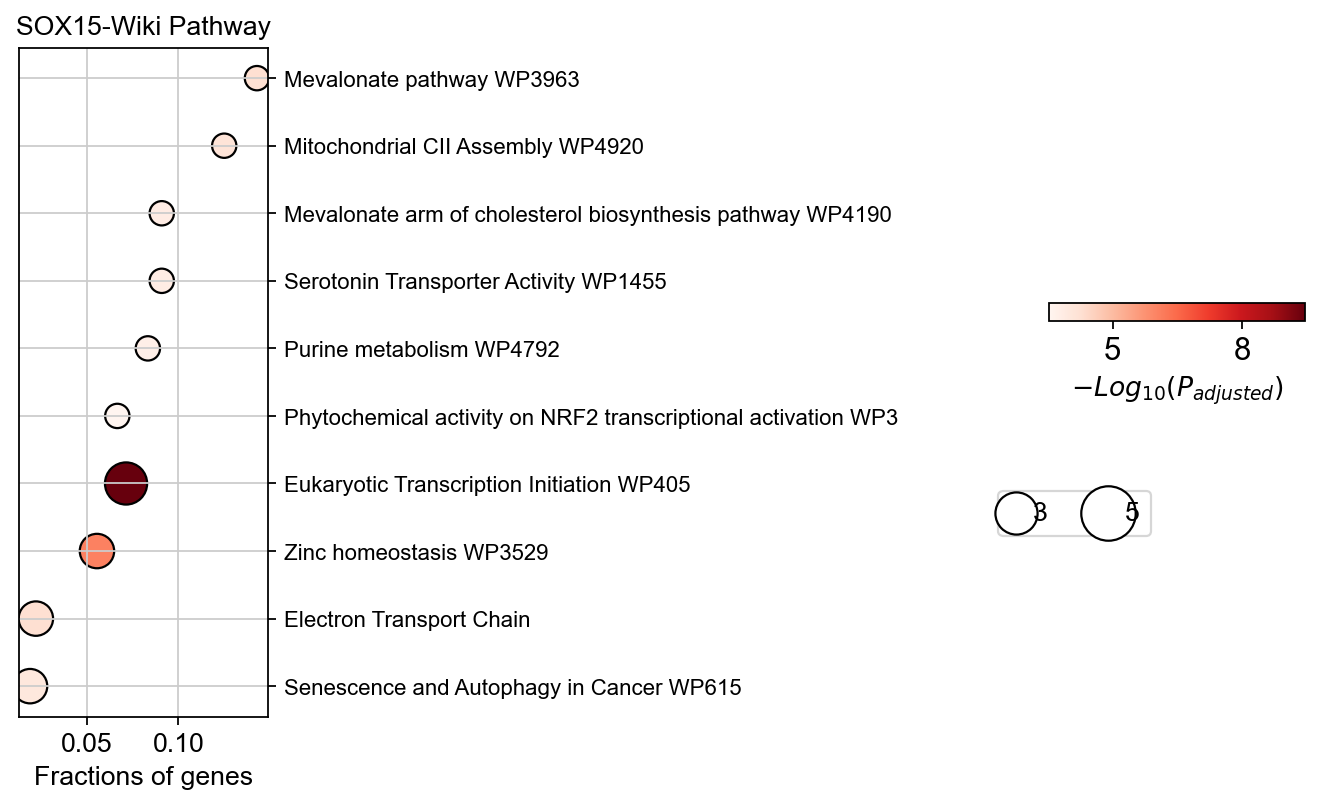

In [139]:
ax=ov.bulk.geneset_plot(enr,figsize=(2,5.5),fig_title='SOX15-Wiki Pathway',
                    cax_loc=[3.4, 0.6, 0.8, 0.02],
                    bbox_to_anchor_used=(-0.25, -13),node_diameter=120,
                    cmap='Reds',custom_ticks=[5,8],text_knock=200,node_size=[3,5])
plt.grid(False)
plt.savefig('/mnt/home/yihanzhao/RB/fig3/SOX15-gsea',dpi=300,bbox_inches='tight')

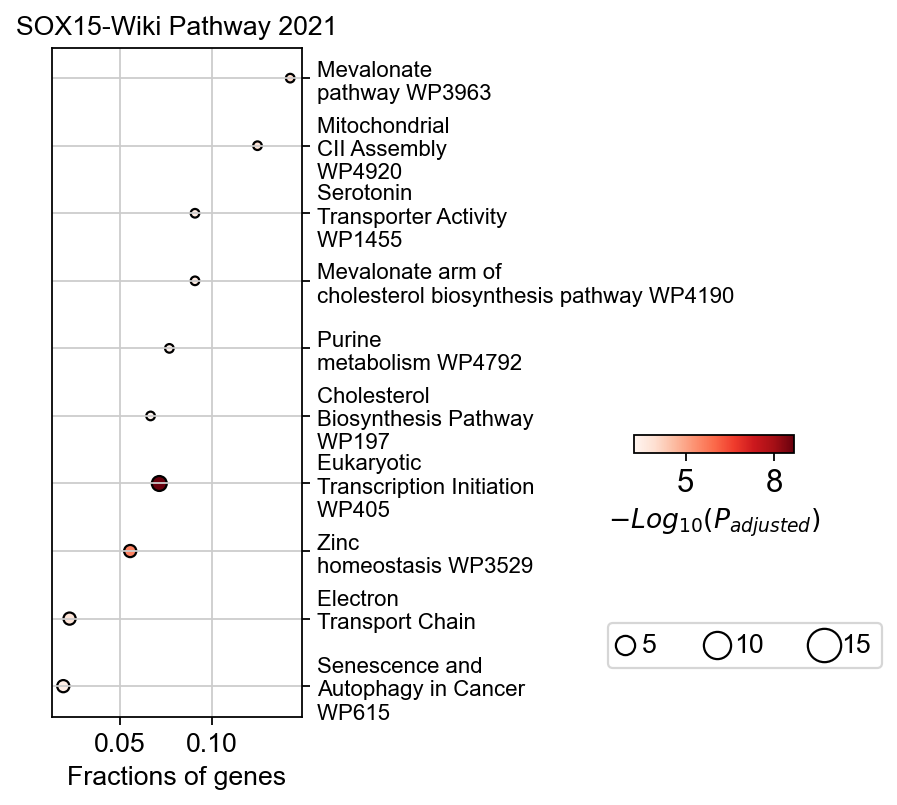

In [50]:
ax=ov.bulk.geneset_plot(enr,figsize=(2,5.5),fig_title='SOX15-Wiki Pathway 2021',
                    cax_loc=[2, 0.45, 0.5, 0.02],
                    bbox_to_anchor_used=(-0.25, -13),node_diameter=15,
                    cmap='Reds',custom_ticks=[5,8])
plt.grid(False)

## NFIL3-GSEA

In [110]:
df3 = pd.read_csv('/mnt/home/yihanzhao/RB/data_new/TF-gene/TF_NFIL3_target_genes(1).csv')

In [111]:
enr=ov.bulk.geneset_enrichment(gene_list=list(df3['target_genes']),
                                pathways_dict=pathway_dict,
                                pvalue_type='normal',
                                organism='human')

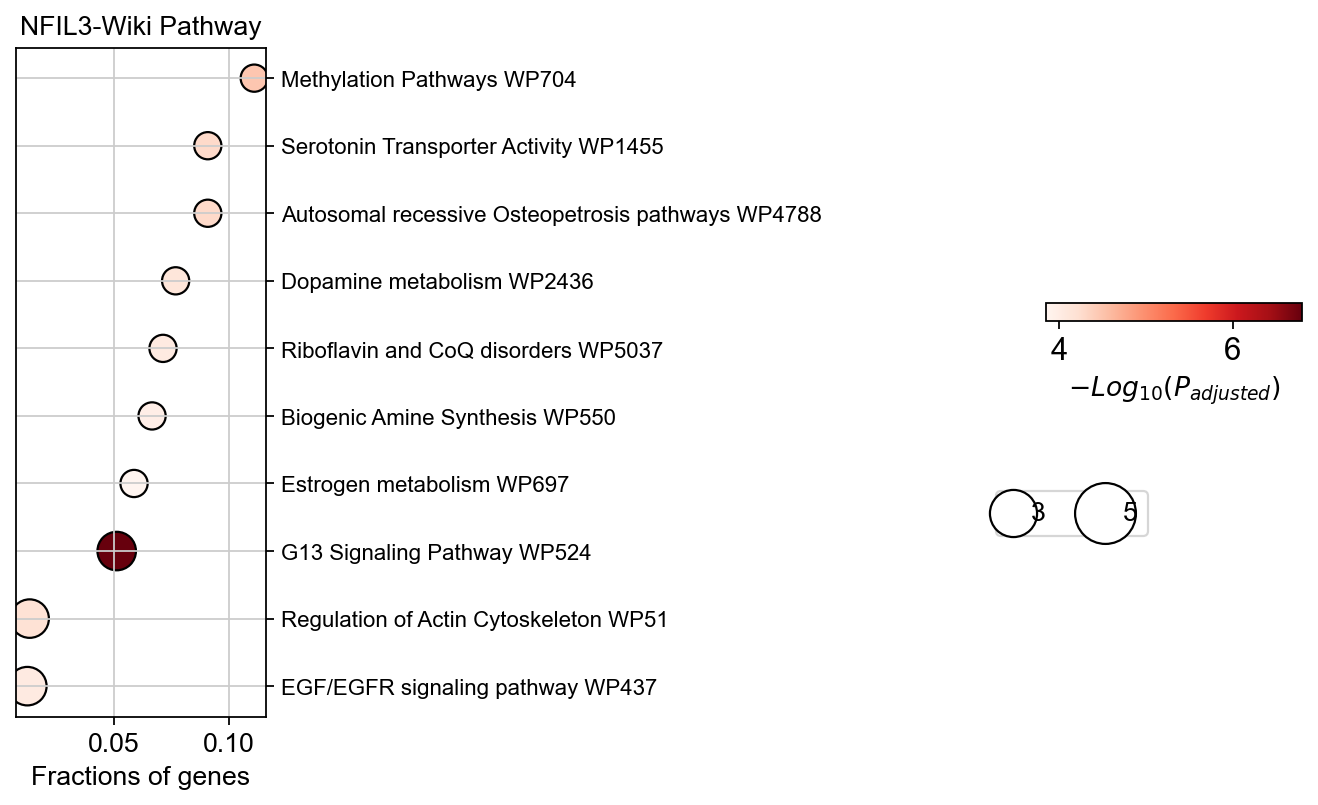

In [135]:
ax=ov.bulk.geneset_plot(enr,figsize=(2,5.5),fig_title='NFIL3-Wiki Pathway',
                    cax_loc=[3.4, 0.6, 0.8, 0.02],
                    bbox_to_anchor_used=(-0.25, -13),node_diameter=150,
                    cmap='Reds',custom_ticks=[4,6],text_knock=200,node_size=[3,5])
plt.grid(False)
plt.savefig('/mnt/home/yihanzhao/RB/fig3/NFIL3-gsea',dpi=300,bbox_inches='tight')

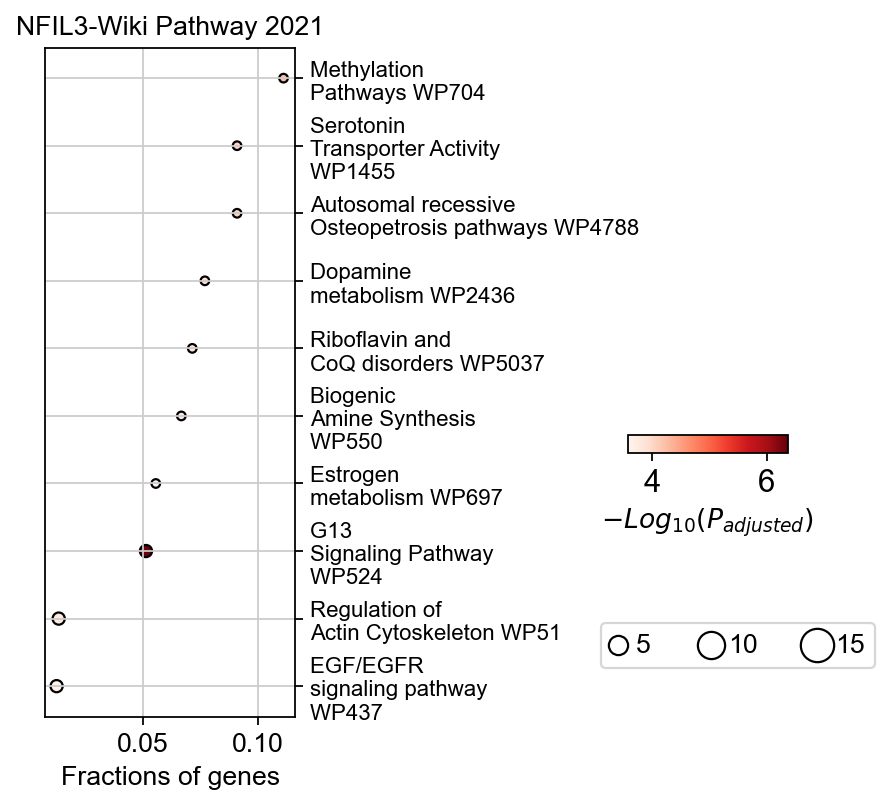

In [47]:
ax=ov.bulk.geneset_plot(enr,figsize=(2,5.5),fig_title='NFIL3-Wiki Pathway 2021',
                    cax_loc=[2, 0.45, 0.5, 0.02],
                    bbox_to_anchor_used=(-0.25, -13),node_diameter=15,
                    cmap='Reds',custom_ticks=[4,6])
plt.grid(False)